# EDA of CAIC data

### Import Libraries

In [6]:
# notebooks/01_eda_caic_avalanches.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data
df = pd.read_csv('../data/processed/caic_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Total observations: {len(df):,}")
print(f"\nDataset shape: {df.shape}")

Total observations: 15,826

Dataset shape: (15826, 10)


### Missing Data Analysis

MISSING DATA ANALYSIS

Columns with missing data:
                Missing Count  Missing %
Observation ID           1474   9.313787
Type                     1434   9.061039
Trigger                   588   3.715405
Aspect                    179   1.131050


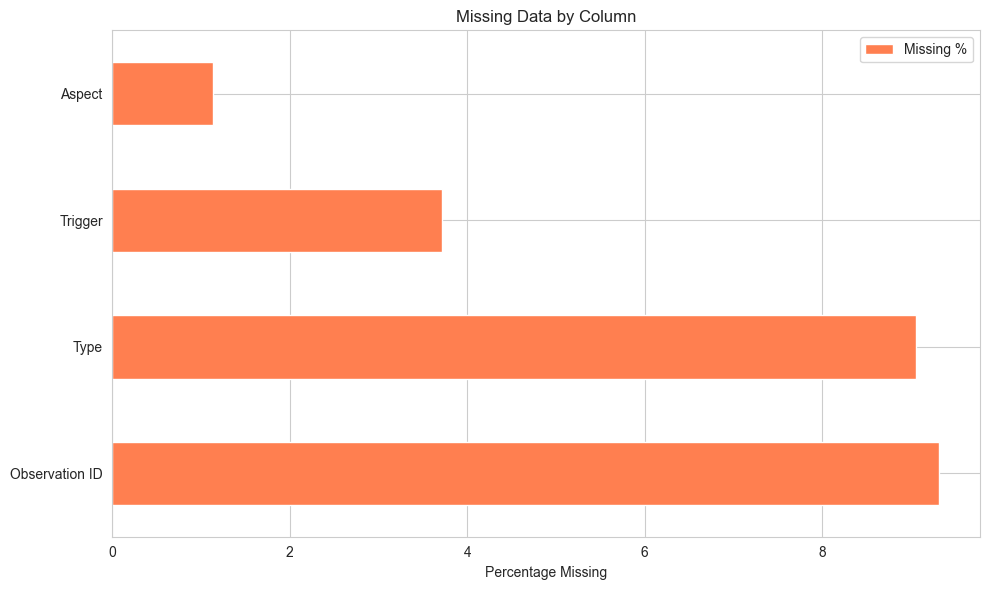


FEATURE COMPLETENESS
Aspect              : 15,647 valid ( 98.9%),    179 missing (  1.1%)
Type                : 14,392 valid ( 90.9%),  1,434 missing (  9.1%)
Trigger             : 15,238 valid ( 96.3%),    588 missing (  3.7%)
Area                : 15,826 valid (100.0%),      0 missing (  0.0%)
avalanche_size      : 15,826 valid (100.0%),      0 missing (  0.0%)

SAMPLE VALUES (to verify cleaning worked)

Aspect - Unique values:
Aspect
E      4406
NE     3611
SE     2300
N      1730
W       973
S       953
NW      950
SW      648
All      42
U        34
Name: count, dtype: int64

Type - Unique values:
Type
SS    8364
HS    2396
WL    1742
WS     651
L      587
U      429
C      183
G       29
R        8
I        3
Name: count, dtype: int64

Trigger - Unique values:
Trigger
N    14410
U      828
Name: count, dtype: int64


In [7]:
# Missing data overview
print("="*60)
print("MISSING DATA ANALYSIS")
print("="*60)

missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

# Only show columns with missing data
if missing_df['Missing Count'].sum() > 0:
    print("\nColumns with missing data:")
    print(missing_df[missing_df['Missing Count'] > 0])
    
    # Visualize missing data
    fig, ax = plt.subplots(figsize=(10, 6))
    missing_df[missing_df['Missing Count'] > 0].plot(
        kind='barh', 
        y='Missing %', 
        ax=ax,
        color='coral'
    )
    ax.set_xlabel('Percentage Missing')
    ax.set_title('Missing Data by Column')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No missing data in any columns!")

# Detail for key feature columns
print("\n" + "="*60)
print("FEATURE COMPLETENESS")
print("="*60)

for col in ['Aspect', 'Type', 'Trigger', 'Area', 'avalanche_size']:
    if col in df.columns:
        missing_count = df[col].isna().sum()
        valid_count = df[col].notna().sum()
        print(f"{col:20s}: {valid_count:6,} valid ({valid_count/len(df)*100:5.1f}%), {missing_count:6,} missing ({missing_count/len(df)*100:5.1f}%)")

# Show examples of valid values for context
print("\n" + "="*60)
print("SAMPLE VALUES (to verify cleaning worked)")
print("="*60)

for col in ['Aspect', 'Type', 'Trigger']:
    if col in df.columns:
        print(f"\n{col} - Unique values:")
        print(df[col].value_counts().head(10))

### Temporal Distribution

TEMPORAL ANALYSIS

Date range: 2016-02-06 07:00:00+00:00 to 2026-02-13 02:13:00+00:00
Span: 3659 days (10.0 years)
Unique dates: 1,661
Average avalanches per reporting day: 9.5


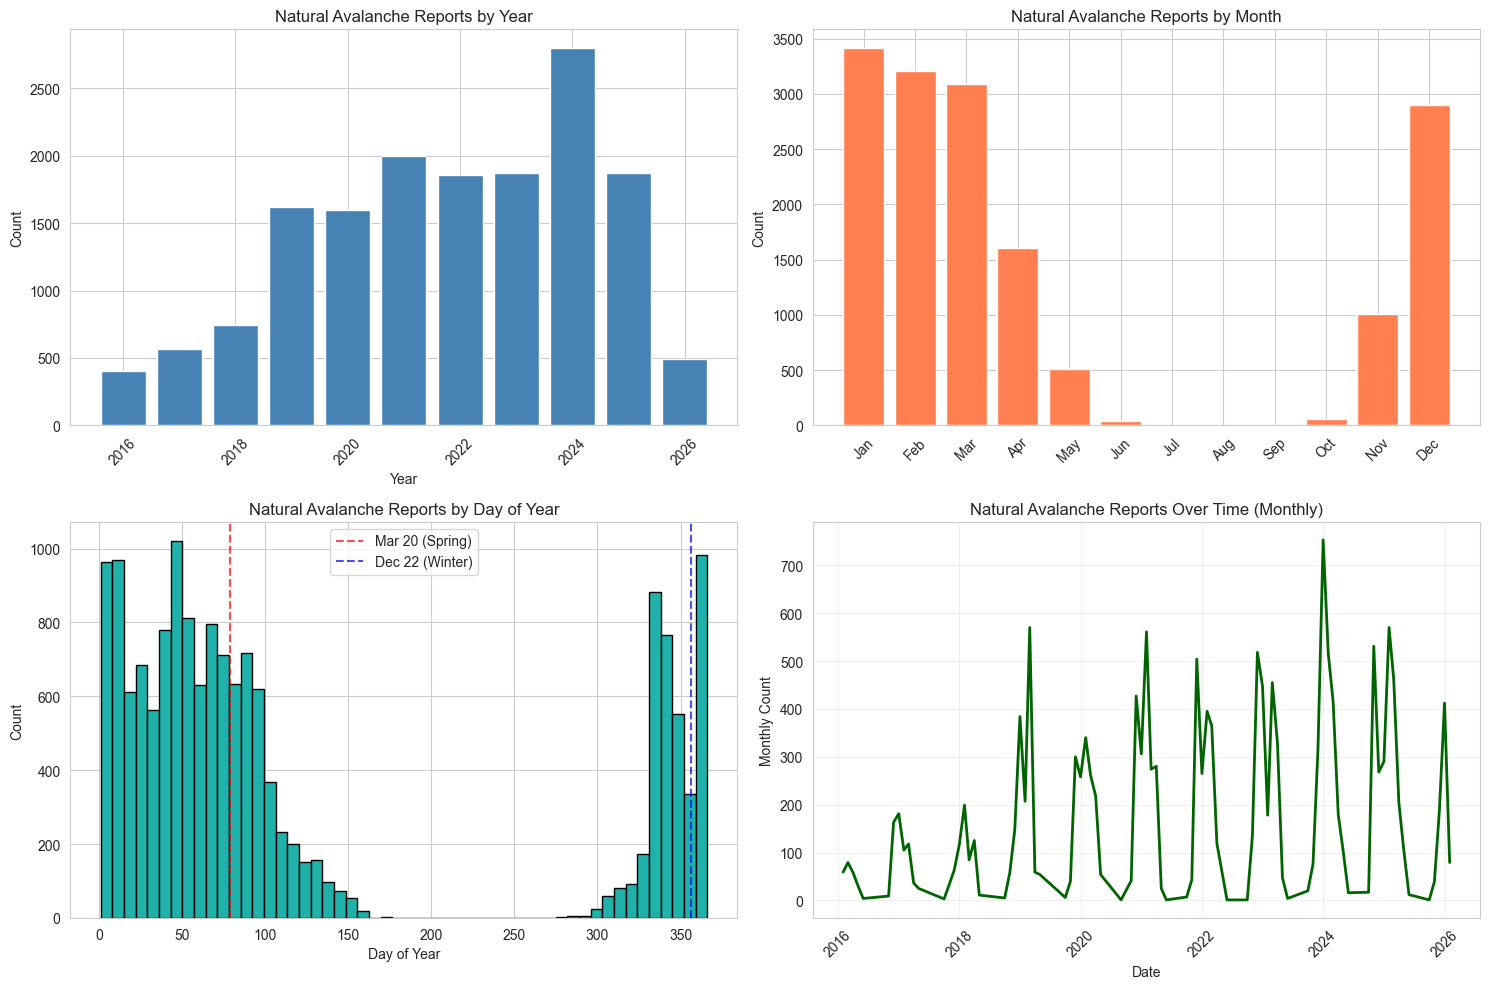


Peak avalanche months:
month
1     3413
2     3208
3     3086
12    2896
4     1606
Name: count, dtype: int64


In [8]:
print("="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Span: {(df['Date'].max() - df['Date'].min()).days} days ({(df['Date'].max() - df['Date'].min()).days/365:.1f} years)")

# Add temporal features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_year'] = df['Date'].dt.dayofyear
df['hour'] = df['Date'].dt.hour

# Count unique dates
unique_dates = df['Date'].dt.date.nunique()
print(f"Unique dates: {unique_dates:,}")
print(f"Average avalanches per reporting day: {len(df)/unique_dates:.1f}")

# Avalanches by year
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# By year
year_counts = df['year'].value_counts().sort_index()
axes[0,0].bar(year_counts.index, year_counts.values, color='steelblue')
axes[0,0].set_title('Natural Avalanche Reports by Year')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# By month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts = df['month'].value_counts().sort_index()
axes[0,1].bar(month_counts.index, month_counts.values, color='coral')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(month_names, rotation=45)
axes[0,1].set_title('Natural Avalanche Reports by Month')
axes[0,1].set_ylabel('Count')

# By day of year (shows seasonality)
axes[1,0].hist(df['day_of_year'], bins=52, color='lightseagreen', edgecolor='black')
axes[1,0].set_title('Natural Avalanche Reports by Day of Year')
axes[1,0].set_xlabel('Day of Year')
axes[1,0].set_ylabel('Count')
axes[1,0].axvline(x=79, color='red', linestyle='--', alpha=0.7, label='Mar 20 (Spring)')
axes[1,0].axvline(x=356, color='blue', linestyle='--', alpha=0.7, label='Dec 22 (Winter)')
axes[1,0].legend()

# Timeline
df_timeline = df.groupby(df['Date'].dt.to_period('M')).size()
axes[1,1].plot(df_timeline.index.to_timestamp(), df_timeline.values, linewidth=2, color='darkgreen')
axes[1,1].set_title('Natural Avalanche Reports Over Time (Monthly)')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Monthly Count')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Peak months
print(f"\nPeak avalanche months:")
print(month_counts.sort_values(ascending=False).head())

### Geographic Distribution

GEOGRAPHIC ANALYSIS

Natural Avalanches by CAIC Region:
Area
Gunnison                 4031
Aspen                    2657
Northern San Juan        2576
Vail & Summit County     1904
Front Range              1652
Sawatch                  1451
Southern San Juan        1235
Steamboat & Flat Tops     248
Sangre de Cristo           44
Grand Mesa                 28
Name: count, dtype: int64


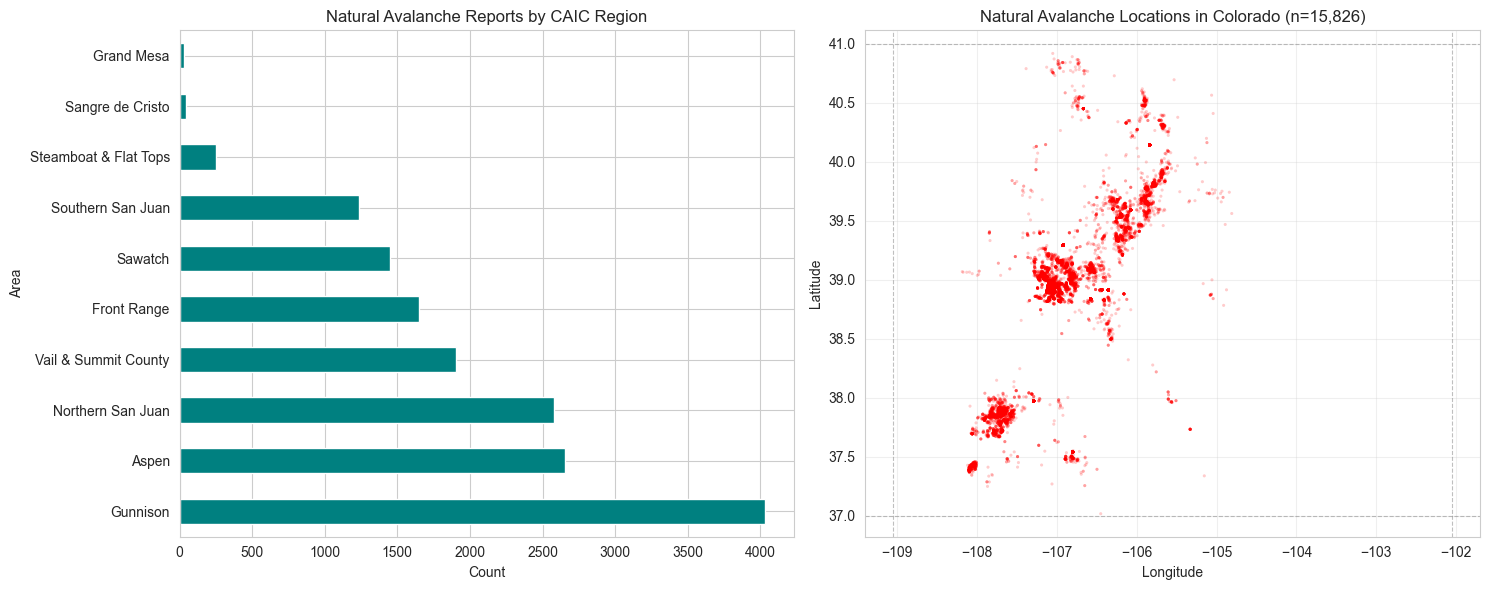


Longitude range: -108.1866 to -104.8107
Latitude range: 37.0164 to 40.9200

Unique coordinate pairs: 6,080
Average reports per location: 2.6


In [9]:
print("="*60)
print("GEOGRAPHIC ANALYSIS")
print("="*60)

# Regional distribution
print("\nNatural Avalanches by CAIC Region:")
region_counts = df['Area'].value_counts()
print(region_counts)

# Plot regions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

region_counts.plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_title('Natural Avalanche Reports by CAIC Region')
axes[0].set_xlabel('Count')

# Geographic scatter with density
scatter = axes[1].scatter(df['Longitude'], df['latitude'], 
                          alpha=0.2, s=5, c='red', edgecolors='none')
axes[1].set_title(f'Natural Avalanche Locations in Colorado (n={len(df):,})')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].grid(True, alpha=0.3)

# Add Colorado approximate boundaries
axes[1].axvline(x=-109.05, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)  # West
axes[1].axvline(x=-102.05, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)  # East
axes[1].axhline(y=37.0, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)     # South
axes[1].axhline(y=41.0, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)     # North

plt.tight_layout()
plt.show()

# Coordinate ranges
print(f"\nLongitude range: {df['Longitude'].min():.4f} to {df['Longitude'].max():.4f}")
print(f"Latitude range: {df['latitude'].min():.4f} to {df['latitude'].max():.4f}")

# Unique locations
unique_locations = df[['Longitude', 'latitude']].drop_duplicates().shape[0]
print(f"\nUnique coordinate pairs: {unique_locations:,}")
print(f"Average reports per location: {len(df)/unique_locations:.1f}")

### Avalanche Characteristics

AVALANCHE CHARACTERISTICS

Avalanche Size Distribution:
avalanche_size
1.0    3960
1.5    3581
2.0    6119
2.5    1297
3.0     630
3.5     112
4.0     124
5.0       3
Name: count, dtype: int64

Mean size: 1.74
Median size: 2.00


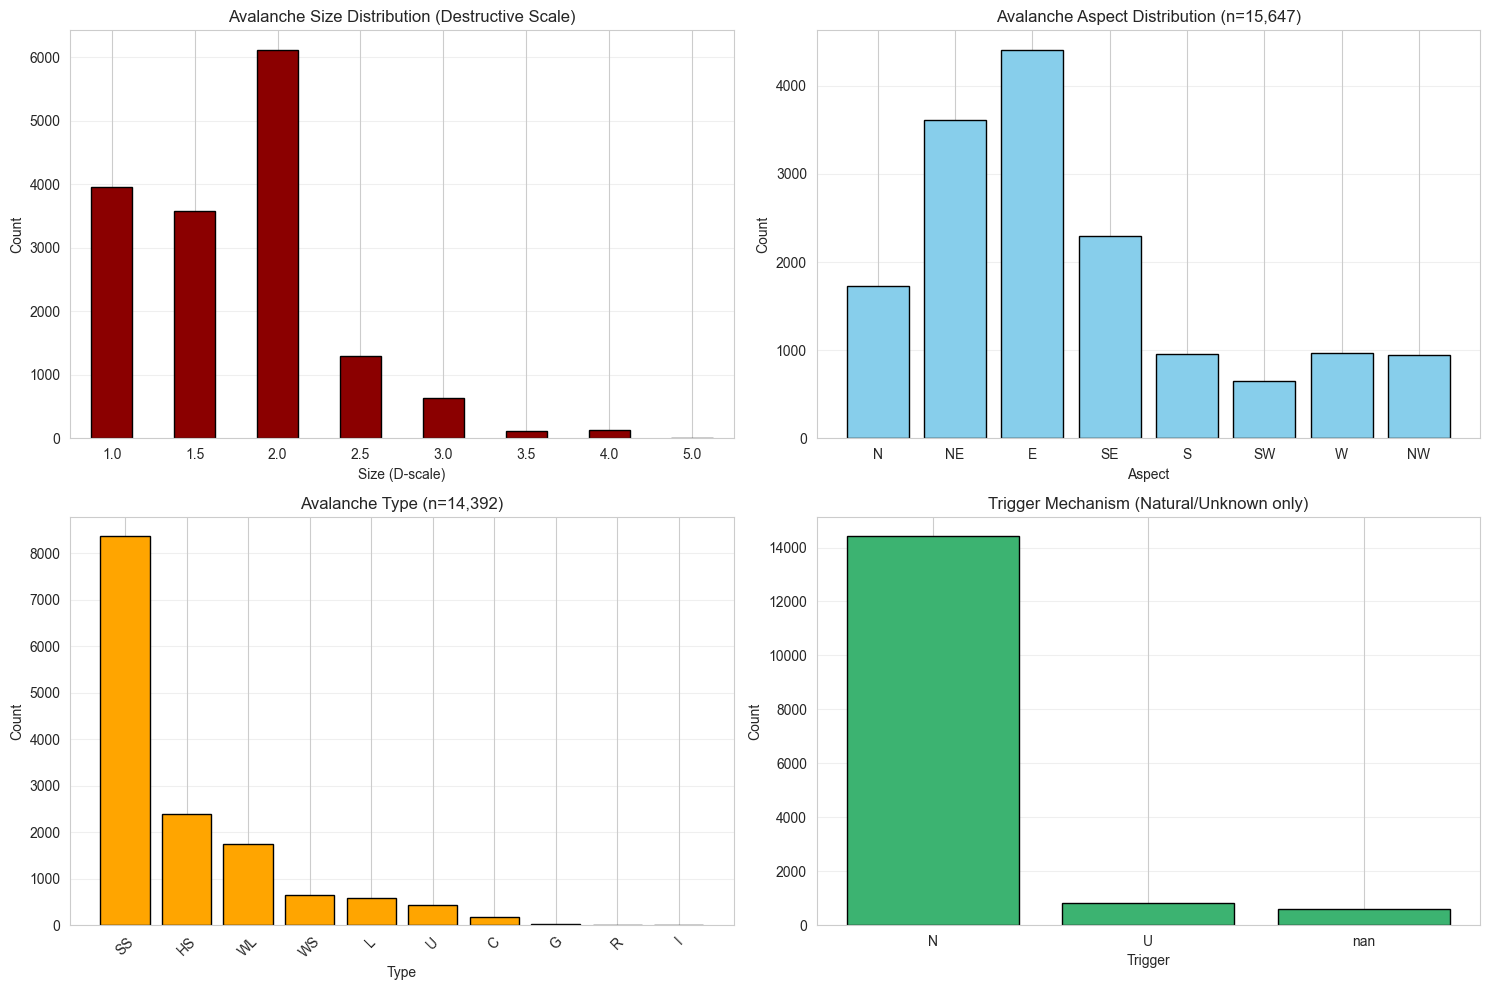


Common Type codes:
Type
SS    8364
HS    2396
WL    1742
WS     651
L      587
U      429
C      183
G       29
R        8
I        3
Name: count, dtype: int64

SS = Storm Slab, HS = Hard Slab, WL = Wet Loose
L = Loose, WS = Wet Slab, U = Unknown, C = Cornice


In [11]:
print("="*60)
print("AVALANCHE CHARACTERISTICS")
print("="*60)

# Avalanche size distribution
print("\nAvalanche Size Distribution:")
size_counts = df['avalanche_size'].value_counts().sort_index()
print(size_counts)
print(f"\nMean size: {df['avalanche_size'].mean():.2f}")
print(f"Median size: {df['avalanche_size'].median():.2f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Size distribution
size_counts.plot(kind='bar', ax=axes[0,0], color='darkred', edgecolor='black')
axes[0,0].set_title('Avalanche Size Distribution (Destructive Scale)')
axes[0,0].set_xlabel('Size (D-scale)')
axes[0,0].set_ylabel('Count')
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=0)
axes[0,0].grid(axis='y', alpha=0.3)

# Aspect distribution
aspect_counts = df['Aspect'].value_counts()
aspect_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
aspect_counts_ordered = aspect_counts.reindex(aspect_order, fill_value=0)

axes[0,1].bar(aspect_counts_ordered.index, aspect_counts_ordered.values, color='skyblue', edgecolor='black')
axes[0,1].set_title(f'Avalanche Aspect Distribution (n={df["Aspect"].notna().sum():,})')
axes[0,1].set_xlabel('Aspect')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].grid(axis='y', alpha=0.3)

# Type distribution
type_counts = df['Type'].value_counts().head(10)
axes[1,0].bar(type_counts.index, type_counts.values, color='orange', edgecolor='black')
axes[1,0].set_title(f'Avalanche Type (n={df["Type"].notna().sum():,})')
axes[1,0].set_xlabel('Type')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Trigger distribution
trigger_counts = df['Trigger'].value_counts(dropna=False)
axes[1,1].bar(range(len(trigger_counts)), trigger_counts.values, 
              color='mediumseagreen', edgecolor='black')
axes[1,1].set_xticks(range(len(trigger_counts)))
axes[1,1].set_xticklabels(trigger_counts.index, rotation=0)
axes[1,1].set_title('Trigger Mechanism (Natural/Unknown only)')
axes[1,1].set_xlabel('Trigger')
axes[1,1].set_ylabel('Count')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCommon Type codes:")
print(df['Type'].value_counts().head(10))
print("\nSS = Storm Slab, HS = Hard Slab, WL = Wet Loose")
print("L = Loose, WS = Wet Slab, U = Unknown, C = Cornice")

### Cross-Tabulations and Relationships

RELATIONSHIPS BETWEEN VARIABLES

Average Avalanche Size by Region:
                           mean  median  count
Area                                          
Gunnison               1.840734    2.00   4031
Aspen                  1.827813    2.00   2657
Southern San Juan      1.772874    2.00   1235
Northern San Juan      1.759511    2.00   2576
Sawatch                1.739835    1.50   1451
Vail & Summit County   1.615546    1.50   1904
Front Range            1.537833    1.50   1652
Sangre de Cristo       1.511364    1.50     44
Steamboat & Flat Tops  1.453629    1.50    248
Grand Mesa             1.375000    1.25     28

Average Avalanche Size by Aspect:
            mean  median  count
Aspect                         
N       1.797688     2.0   1730
NE      1.799778     2.0   3611
E       1.734793     2.0   4406
SE      1.704130     1.5   2300
S       1.655824     1.5    953
SW      1.674383     1.5    648
W       1.710175     1.5    973
NW      1.817368     2.0    950

Average Avala

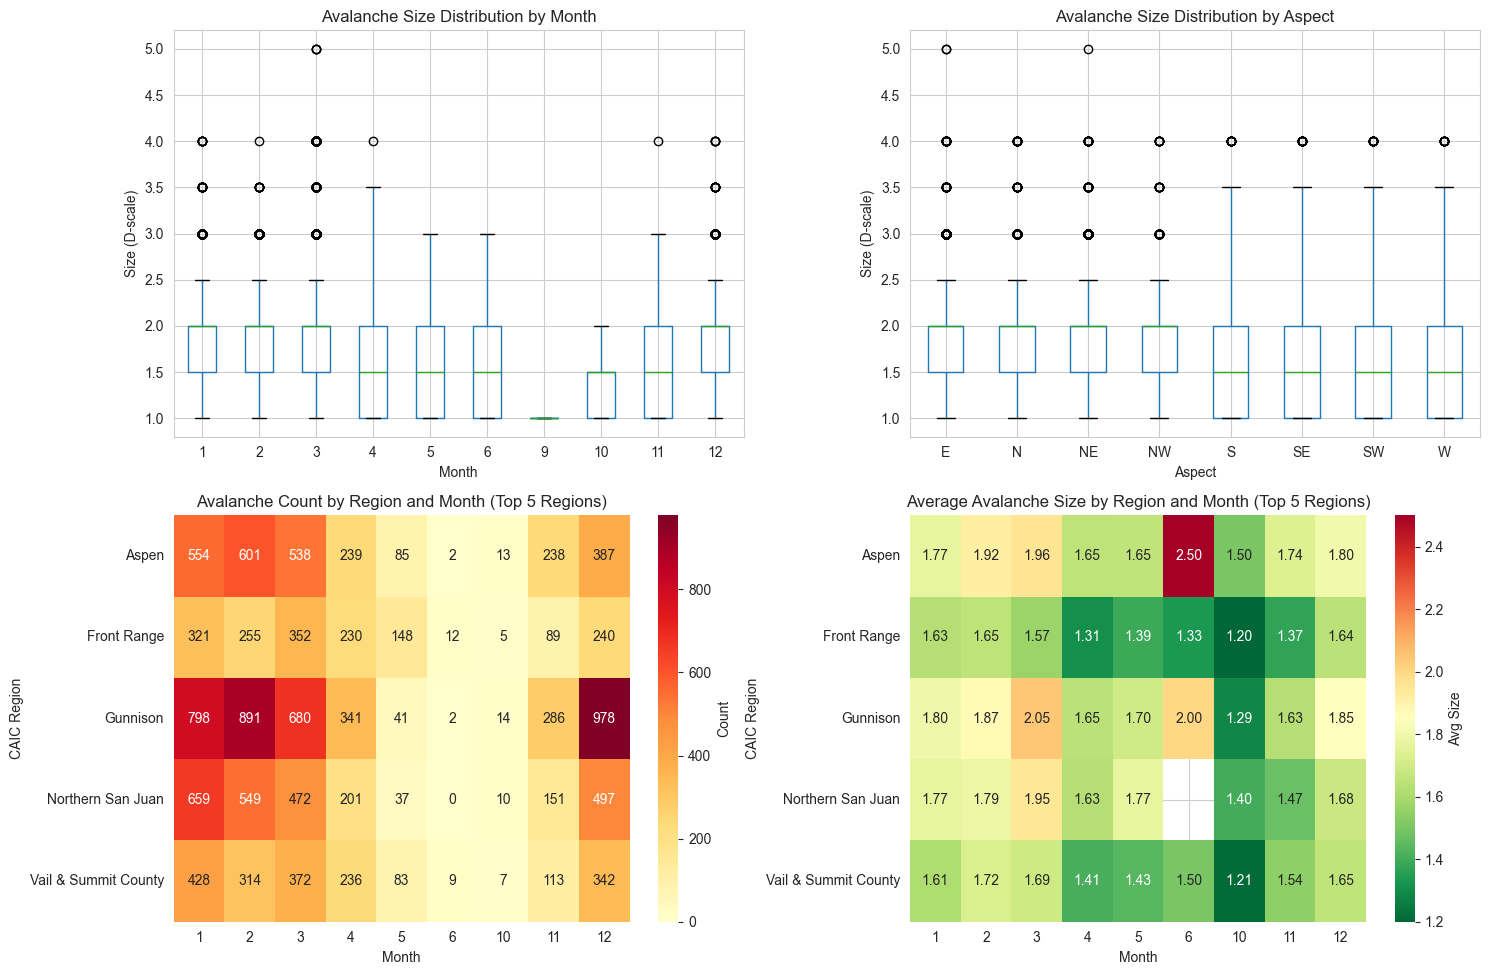

In [12]:
print("="*60)
print("RELATIONSHIPS BETWEEN VARIABLES")
print("="*60)

# Size by region
print("\nAverage Avalanche Size by Region:")
region_size = df.groupby('Area')['avalanche_size'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(region_size)

# Size by aspect (where aspect is known)
print("\nAverage Avalanche Size by Aspect:")
aspect_size = df[df['Aspect'].notna()].groupby('Aspect')['avalanche_size'].agg(['mean', 'median', 'count'])
aspect_size = aspect_size.reindex(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
print(aspect_size)

# Size by month
print("\nAverage Avalanche Size by Month:")
month_size = df.groupby('month')['avalanche_size'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
print(month_size)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Size by month boxplot
df.boxplot(column='avalanche_size', by='month', ax=axes[0,0])
axes[0,0].set_title('Avalanche Size Distribution by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Size (D-scale)')
axes[0,0].get_figure().suptitle('')  # Remove automatic title

# Size by aspect boxplot
aspect_data = df[df['Aspect'].isin(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])]
aspect_data.boxplot(column='avalanche_size', by='Aspect', ax=axes[0,1])
axes[0,1].set_title('Avalanche Size Distribution by Aspect')
axes[0,1].set_xlabel('Aspect')
axes[0,1].set_ylabel('Size (D-scale)')
axes[0,1].get_figure().suptitle('')

# Heatmap: Count by Month and Region (top 5 regions)
top_regions = region_counts.head(5).index
pivot_count = df[df['Area'].isin(top_regions)].pivot_table(
    values='avalanche_size', 
    index='Area', 
    columns='month', 
    aggfunc='count',
    fill_value=0
)
sns.heatmap(pivot_count, annot=True, fmt='g', cmap='YlOrRd', ax=axes[1,0], cbar_kws={'label': 'Count'})
axes[1,0].set_title('Avalanche Count by Region and Month (Top 5 Regions)')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('CAIC Region')

# Heatmap: Average Size by Month and Region
pivot_size = df[df['Area'].isin(top_regions)].pivot_table(
    values='avalanche_size', 
    index='Area', 
    columns='month', 
    aggfunc='mean'
)
sns.heatmap(pivot_size, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1,1], cbar_kws={'label': 'Avg Size'})
axes[1,1].set_title('Average Avalanche Size by Region and Month (Top 5 Regions)')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('CAIC Region')

plt.tight_layout()
plt.show()

### Temporal Patterns

TEMPORAL PATTERNS

Avalanches by Day of Week:
day_of_week
Monday       1849
Tuesday      2042
Wednesday    2246
Thursday     2171
Friday       2261
Saturday     2693
Sunday       2564
Name: count, dtype: int64


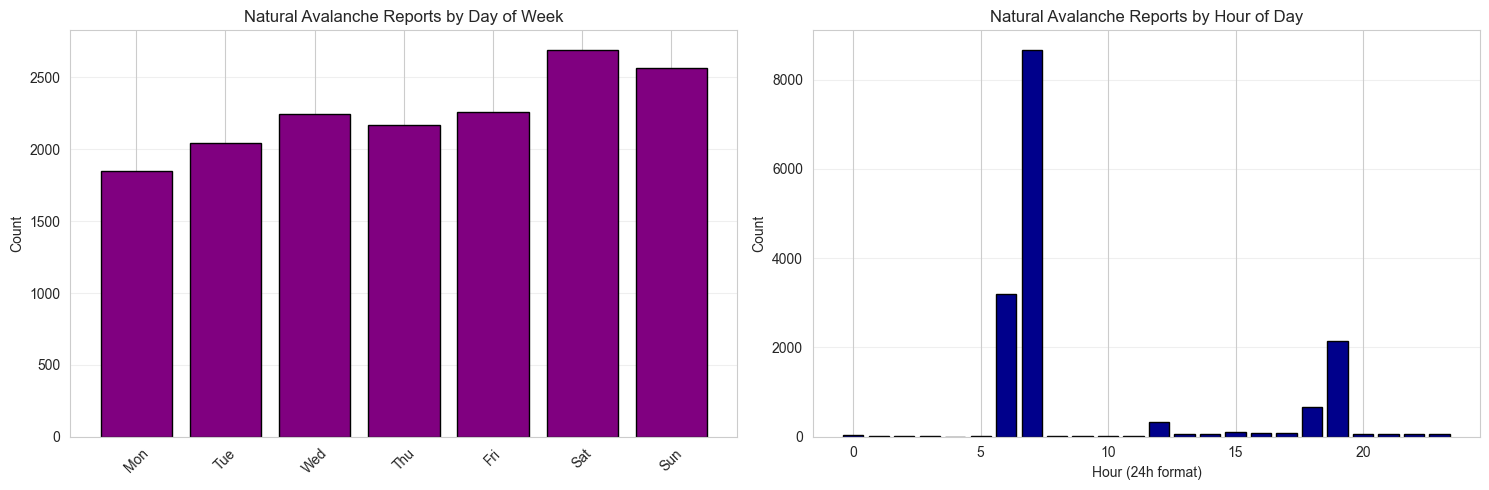


Note: Day of week patterns may reflect reporting patterns rather than actual avalanche occurrence.


In [13]:
print("="*60)
print("TEMPORAL PATTERNS")
print("="*60)

# Avalanche activity by day of week
df['day_of_week'] = df['Date'].dt.day_name()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df['day_of_week'].value_counts().reindex(dow_order)

print("\nAvalanches by Day of Week:")
print(dow_counts)

# Avalanche activity by hour (if meaningful)
hour_counts = df['hour'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Day of week
axes[0].bar(range(7), dow_counts.values, color='purple', edgecolor='black')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=45)
axes[0].set_title('Natural Avalanche Reports by Day of Week')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Time of day (if there's meaningful variation)
if hour_counts.sum() > 0:
    axes[1].bar(hour_counts.index, hour_counts.values, color='darkblue', edgecolor='black')
    axes[1].set_title('Natural Avalanche Reports by Hour of Day')
    axes[1].set_xlabel('Hour (24h format)')
    axes[1].set_ylabel('Count')
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No hour data available', 
                 ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Hour of Day (No Data)')

plt.tight_layout()
plt.show()

print("\nNote: Day of week patterns may reflect reporting patterns rather than actual avalanche occurrence.")

### Data Pipeline Scope

In [14]:
print("="*60)
print("DATA PIPELINE SCOPE")
print("="*60)

unique_dates = df['Date'].dt.date.nunique()
unique_locations = df[['Longitude', 'latitude']].drop_duplicates().shape[0]
unique_location_dates = df[['Longitude', 'latitude', 'Date']].drop_duplicates().shape[0]
unique_years = df['year'].nunique()

print(f"\nDataset Statistics:")
print(f"  Total observations: {len(df):,}")
print(f"  Unique dates: {unique_dates:,}")
print(f"  Unique locations: {unique_locations:,}")
print(f"  Unique location+date combinations: {unique_location_dates:,}")
print(f"  Date range: {unique_years} years")

print(f"\nData Fetching Requirements:")
print(f"  SNOTEL queries needed: ~{unique_dates:,} dates")
print(f"    (Across ~50-100 Colorado SNOTEL stations)")
print(f"    (Many dates will reuse same station data)")
print(f"  ")
print(f"  DEM/terrain queries needed: {unique_locations:,} unique coordinates")
print(f"    (One-time extraction, then cached)")

print(f"\nNegative Sampling Target:")
print(f"  Current positives: {len(df):,}")
print(f"  Suggested negatives: {len(df)*2:,} (2:1 ratio)")
print(f"  Total training set: {len(df)*3:,} observations")

# Dates per year
print(f"\nTemporal distribution:")
dates_per_year = df.groupby('year')['Date'].apply(lambda x: x.dt.date.nunique())
print(dates_per_year)

DATA PIPELINE SCOPE

Dataset Statistics:
  Total observations: 15,826
  Unique dates: 1,661
  Unique locations: 6,080
  Unique location+date combinations: 9,596
  Date range: 11 years

Data Fetching Requirements:
  SNOTEL queries needed: ~1,661 dates
    (Across ~50-100 Colorado SNOTEL stations)
    (Many dates will reuse same station data)
  
  DEM/terrain queries needed: 6,080 unique coordinates
    (One-time extraction, then cached)

Negative Sampling Target:
  Current positives: 15,826
  Suggested negatives: 31,652 (2:1 ratio)
  Total training set: 47,478 observations

Temporal distribution:
year
2016    119
2017    130
2018    153
2019    167
2020    169
2021    165
2022    181
2023    173
2024    204
2025    161
2026     39
Name: Date, dtype: int64


### Data Quality Summary

In [15]:
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

# Check for duplicates
duplicate_obs_id = df['Observation ID'].duplicated().sum()
duplicate_location_date = df[['Longitude', 'latitude', 'Date']].duplicated().sum()

print(f"\nDuplicate Check:")
print(f"  Duplicate Observation IDs: {duplicate_obs_id}")
print(f"  Duplicate location+date combinations: {duplicate_location_date}")

# Coordinate bounds check (Colorado approximate boundaries)
colorado_lon_range = (-109.1, -102.0)
colorado_lat_range = (36.9, 41.1)

outside_bounds = (
    (df['Longitude'] < colorado_lon_range[0]) | 
    (df['Longitude'] > colorado_lon_range[1]) |
    (df['latitude'] < colorado_lat_range[0]) | 
    (df['latitude'] > colorado_lat_range[1])
).sum()

print(f"\nGeographic Validation:")
print(f"  Observations outside Colorado bounds: {outside_bounds}")
print(f"  All observations within bounds: {outside_bounds == 0}")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(df[['avalanche_size', 'Longitude', 'latitude', 'year', 'month']].describe())


DATA QUALITY SUMMARY

Duplicate Check:
  Duplicate Observation IDs: 8085
  Duplicate location+date combinations: 6230

Geographic Validation:
  Observations outside Colorado bounds: 0
  All observations within bounds: True

SUMMARY STATISTICS
       avalanche_size     Longitude      latitude          year         month
count    15826.000000  15826.000000  15826.000000  15826.000000  15826.000000
mean         1.744282   -106.798262     38.897448   2021.794705      4.721345
std          0.592188      0.627283      0.747496      2.521265      4.174996
min          1.000000   -108.186618     37.016422   2016.000000      1.000000
25%          1.000000   -107.184028     38.674073   2020.000000      2.000000
50%          2.000000   -106.856672     38.959440   2022.000000      3.000000
75%          2.000000   -106.321325     39.361731   2024.000000     10.000000
max          5.000000   -104.810658     40.920011   2026.000000     12.000000


### Key Insights Summary

In [16]:
print("\n" + "="*60)
print("KEY INSIGHTS FOR MODEL DEVELOPMENT")
print("="*60)

peak_month = month_counts.idxmax()
peak_region = region_counts.index[0]
most_common_aspect = aspect_counts_ordered.idxmax()
most_common_size = size_counts.idxmax()

print(f"""
1. DATASET SIZE:
   - {len(df):,} natural avalanche observations
   - {unique_dates:,} unique dates over {unique_years} years
   - {unique_locations:,} unique locations
   
2. TEMPORAL PATTERNS:
   - Peak month: {month_names[peak_month-1]} ({month_counts[peak_month]:,} avalanches)
   - Most active season: Winter (Dec-Mar)
   - Date range: {df['Date'].min().date()} to {df['Date'].max().date()}
   
3. GEOGRAPHIC DISTRIBUTION:
   - Most reports: {peak_region} ({region_counts.iloc[0]:,} avalanches)
   - {len(region_counts)} CAIC regions covered
   - Good statewide coverage
   
4. AVALANCHE CHARACTERISTICS:
   - Most common size: D{most_common_size} ({size_counts.iloc[size_counts.argmax()]:,} avalanches)
   - Mean size: D{df['avalanche_size'].mean():.2f}
   - Most common aspect: {most_common_aspect} ({aspect_counts_ordered[most_common_aspect]:,} avalanches)
   - Aspect missing: {df['Aspect'].isna().sum():,} ({df['Aspect'].isna().sum()/len(df)*100:.1f}%)
   
5. DATA COMPLETENESS:
   - Aspect: {(1 - df['Aspect'].isna().sum()/len(df))*100:.1f}% complete (will supplement with DEM)
   - Type: {(1 - df['Type'].isna().sum()/len(df))*100:.1f}% complete
   - All critical fields (date, location, size): 100% complete
   
6. NEXT STEPS:
   - Extract terrain features for {unique_locations:,} locations
   - Fetch weather data for ~{unique_dates:,} dates
   - Generate ~{len(df)*2:,} negative examples
   - Final dataset: ~{len(df)*3:,} total observations
""")


KEY INSIGHTS FOR MODEL DEVELOPMENT

1. DATASET SIZE:
   - 15,826 natural avalanche observations
   - 1,661 unique dates over 11 years
   - 6,080 unique locations

2. TEMPORAL PATTERNS:
   - Peak month: Jan (3,413 avalanches)
   - Most active season: Winter (Dec-Mar)
   - Date range: 2016-02-06 to 2026-02-13

3. GEOGRAPHIC DISTRIBUTION:
   - Most reports: Gunnison (4,031 avalanches)
   - 10 CAIC regions covered
   - Good statewide coverage

4. AVALANCHE CHARACTERISTICS:
   - Most common size: D2.0 (6,119 avalanches)
   - Mean size: D1.74
   - Most common aspect: E (4,406 avalanches)
   - Aspect missing: 179 (1.1%)

5. DATA COMPLETENESS:
   - Aspect: 98.9% complete (will supplement with DEM)
   - Type: 90.9% complete
   - All critical fields (date, location, size): 100% complete

6. NEXT STEPS:
   - Extract terrain features for 6,080 locations
   - Fetch weather data for ~1,661 dates
   - Generate ~31,652 negative examples
   - Final dataset: ~47,478 total observations

